In [1]:
from tg.grammar_ru import *
from tg.grammar_ru.features import *
import pandas as pd
import numpy as np
import os

In [187]:
rucoco_dir = Loc.data_cache_path/'rucoco'

def get_frames():
    for entry in os.scandir(rucoco_dir/'frames3'):
        yield pd.read_csv(entry).drop(columns=['Unnamed: 0'])

for i in get_frames():
    frame = i
    break

word_to_normal_form = DataBundle.load(rucoco_dir/'bundle-full.zip').words.set_index('word').nf_n.to_dict()
db = DataBundle(src=frame)
pmph = PyMorphyFeaturizer()
pmph.featurize(db)
slvnt = SlovnetFeaturizer()
slvnt.featurize(db)

In [210]:
def _get_pronouns(db: DataBundle):
    morphology_df = db.pymorphy
    pronouns_filter = morphology_df['normal_form'].isin(['он', 'она', 'оно'])
    pronouns_df = morphology_df[pronouns_filter][['gender']]
    pronouns_df = pronouns_df.reset_index()
    return pronouns_df.add_prefix('pronoun_')

def get_annotated_only(db, df):
    pronouns = db.src.word_id.isin(df.pronoun_word_id)
    annotated_filter = (db.src[pronouns].category > 0)
    annotated = df[annotated_filter.reset_index(drop=True)]
    not_first_filter = annotated.pronoun_word_id.apply(lambda x: db.src.category.eq(db.src.iloc[x].category).idxmax() != x)
    return annotated[not_first_filter].reset_index(drop=True)

In [193]:
def get_candidates_oldest_filter(db, pronouns_df, max_candidates=10):
    if len(pronouns_df) == 0:
        return None
    cand_filter = (db.slovnet['POS'].isin(['NOUN', 'PROPN']) &
                   (db.slovnet['Number'] == 'Sing')).reset_index(drop=True)
    candidates_df = db.pymorphy[cand_filter][['gender']]
    candidates_df = candidates_df[['gender']].reset_index().add_prefix('candidate_')
    merged_df = pronouns_df.merge(candidates_df, how='cross')
    merged_df = merged_df[
        (merged_df['pronoun_word_id'] > merged_df['candidate_word_id']) &
        (merged_df['pronoun_gender'] == merged_df['candidate_gender'])]
    merged_df = merged_df.drop(
        columns=['pronoun_gender', 'candidate_gender']).reset_index(
        drop=True)
    merged_df['candidate_distance'] = merged_df.groupby(['pronoun_word_id']).cumcount(ascending=False)
    merged_df = merged_df[merged_df['candidate_distance'] < max_candidates]
    return merged_df[['pronoun_word_id',
                      'candidate_word_id',
                      'candidate_distance']].reset_index(drop=True)

In [194]:
def get_candidates_new_filter(db, pronouns_df):
    if len(pronouns_df) == 0:
        return None
    cand_filter = ((db.slovnet['POS'].isin(['NOUN', 'PROPN']) | (db.slovnet['Animacy'] == 'Anim')) &
                   (db.slovnet['Number'] == 'Sing')).reset_index(drop=True)
    candidates_df = db.pymorphy[cand_filter][['gender']]
    candidates_df = candidates_df[['gender']].reset_index().add_prefix('candidate_')
    merged_df = pronouns_df.merge(candidates_df, how='cross')
    merged_df = merged_df[
        (merged_df['pronoun_word_id'] > merged_df['candidate_word_id']) &
        ((merged_df['pronoun_gender'] == merged_df['candidate_gender']) | merged_df['candidate_gender'].isna())]
    return merged_df

Check how many right pulls of candidates

In [206]:
pronouns_total = 0
correct_candidates = 0
wrong_id_frames = 0
empty_frames = 0

def test_candidate_search(func):
    pronouns_total = 0
    correct_candidates = 0
    wrong_id_frames = 0
    empty_frames = 0
    for frame in get_frames():
        if frame.iloc[-1].name != frame.iloc[-1].word_id:
            wrong_id_frames += 1
            continue
        db = DataBundle(src=frame)
        pmph.featurize(db)
        slvnt.featurize(db)
        pronouns = get_annotated_only(db, _get_pronouns(db))
        candidates = func(db, pronouns)
        if candidates is None:
            empty_frames += 1
            continue
        candidates = candidates.merge(db.src[['word_id', 'category']], left_on='pronoun_word_id', right_on='word_id')
        candidates = candidates.merge(db.src[['word_id', 'category']], left_on='candidate_word_id', right_on='word_id')
        candidates['match'] = candidates.category_x == candidates.category_y
        correct_candidates += candidates.groupby('pronoun_word_id')['match'].any().sum()
        pronouns_total += len(candidates.groupby('pronoun_word_id'))
    return pronouns_total, correct_candidates, wrong_id_frames, empty_frames

In [211]:
pronouns_total, correct_candidates, wrong_id_frames, empty_frames = test_candidate_search(get_candidates_oldest_filter)
pronouns_total, correct_candidates, correct_candidates / pronouns_total, wrong_id_frames, empty_frames

(6725, 4507, 0.670185873605948, 0, 878)

In [212]:
pronouns_total, correct_candidates, wrong_id_frames, empty_frames = test_candidate_search(get_candidates_new_filter)
pronouns_total, correct_candidates, correct_candidates / pronouns_total, wrong_id_frames, empty_frames

(6728, 5426, 0.8064803804994055, 0, 878)

In [238]:
def get_candidates_no_gender_filter(db, pronouns_df, ):
    if len(pronouns_df) == 0:
        return None
    cand_filter = ((db.slovnet['POS'].isin(['NOUN', 'PROPN']) | (db.slovnet['Animacy'] == 'Anim')) &
                   (db.slovnet['Number'] == 'Sing')).reset_index(drop=True)
    candidates_df = db.pymorphy[cand_filter][['gender']]
    candidates_df = candidates_df[['gender']].reset_index().add_prefix('candidate_')
    merged_df = pronouns_df.merge(candidates_df, how='cross')
    merged_df = merged_df[(merged_df['pronoun_word_id'] > merged_df['candidate_word_id'])]
    
    merged_df = merged_df.drop(columns=['pronoun_gender', 'candidate_gender']).reset_index(drop=True)
    merged_df['candidate_distance'] = merged_df.groupby(['pronoun_word_id']).cumcount(ascending=False)
    #merged_df = merged_df[merged_df['candidate_distance'] < 100]
    return merged_df[['pronoun_word_id',
                      'candidate_word_id',
                      'candidate_distance']].reset_index(drop=True)

In [ ]:
pronouns_total, correct_candidates, wrong_id_frames, empty_frames = test_candidate_search(get_candidates_no_gender_filter)
pronouns_total, correct_candidates, correct_candidates / pronouns_total

Added vectors:

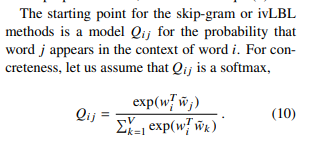

In [240]:
vectors_file = rucoco_dir/'glove'/'output.txt'
vdf = pd.read_csv(vectors_file, sep=' ',header=None).set_index(0)
vdf = vdf.reset_index(drop=True).iloc[:-1]
vdf.columns=list(range(vdf.shape[1]))
vdf.index.name='index'
vdf.loc[len(vdf)] = 0

In [340]:
words_df = vdf.iloc[:, :300]
contexts_df = vdf.iloc[:, 301:601].T.reset_index(drop=True).T.reset_index(drop=True)

In [362]:
# nfn_to_probability_in_contexts = []
# for i in range(len(vdf)):
#     word_vec = words_df.iloc[i]
#     nfn_to_probability_in_contexts.append(np.exp((contexts_df * word_vec).sum(axis=1)).sum())
with open(rucoco_dir/'glove'/'context_sums', 'rb') as file:
    nfn_to_probability_in_contexts = pickle.load(file)

In [398]:
def get_context_words(db, with_parents_df, neighb_count=1):
    extended_df = with_parents_df.copy()
    
    for i in range(1, neighb_count + 1):
        left_id = 'left_id_' + str(i)
        extended_df[left_id] = with_parents_df['pronoun_word_id'].apply(
            lambda x: x - i if (x - i >= 0 and db.src.loc[x - i].word_type != 'punct') else -1)
        right_id = 'right_id_' + str(i)
        extended_df[right_id] = with_parents_df['pronoun_word_id'].apply(
            lambda x: x + i if (x + i < len(db.src.index) and db.src.loc[x + i].word_type != 'punct') else -1)
        
        extended_df = extended_df.merge(
            db.src.word.str.lower().rename('left_word_' + str(i)),
            left_on=left_id, right_index=True, how='left').reset_index(drop=True)
        extended_df = extended_df.merge(
            db.src.word.str.lower().rename('right_word_' + str(i)),
            left_on=right_id, right_index=True, how='left').reset_index(
            drop=True)
    extended_df = extended_df.merge(
            db.src.word.str.lower().rename('parent_word'),
            left_on='pronoun_parent_id', right_index=True, how='left')
    return extended_df.fillna('')
        
def get_nf_n(word):
    try:
        if word_to_normal_form[word.lower()] > 0:
            return word_to_normal_form[word.lower()]
        return vdf.iloc[len(vdf) - 1]
    except (KeyError, AttributeError):
        return vdf.iloc[len(vdf) - 1]
        
def get_glove_prod_e_norm(df, col1, col2):
    copy = df.copy()
    nf1 = copy[col1].apply(lambda a: get_nf_n(a))
    nf2 = copy[col2].apply(lambda a: get_nf_n(a))
    v1 = words_df.iloc[nf1].reset_index(drop=True)
    v2 = contexts_df.iloc[nf2].reset_index(drop=True)
    sc_prod = np.exp((v1 * v2).sum(axis=1))
    exps_sum = nf1.apply(lambda x: nfn_to_probability_in_contexts[x])
    prods = sc_prod / exps_sum
    copy['prod_e'] = prods
    return copy.groupby('pronoun_word_id')['prod_e'].transform(lambda x: x / x.sum()).fillna(0)

def get_result_score(db, with_parents_df, neighb_count=1, no_parent=False, coeff=1):
    with_parents_df = (with_parents_df.merge(db.src[['word_id', 'word']], left_on='candidate_word_id', right_on='word_id', how='left')
                       .rename(columns={'word': 'candidate_word'}))
    extended_df = get_context_words(db, with_parents_df, neighb_count)
    result_series = get_glove_prod_e_norm(extended_df, 'candidate_word', 'parent_word')
    if no_parent:
        result_series['score'] = 0
    if neighb_count == 0:
        return result_series
    for i in range(1, neighb_count + 1):
        i_addendum = (get_glove_prod_e_norm(extended_df,
                                            'candidate_word',
                                            'left_word_' + str(i)) +
                      get_glove_prod_e_norm(extended_df,
                                            'candidate_word',
                                            'right_word_' + str(i)))
        result_series += i_addendum * coeff
    return result_series

In [430]:
pmph = PyMorphyFeaturizer()
slvnt = SlovnetFeaturizer()
total = 0
success = 0

for frame in get_frames():
    db = DataBundle(src=frame)
    pmph.featurize(db)
    slvnt.featurize(db)
    pronouns = get_annotated_only(db, _get_pronouns(db))
    candidates = get_candidates_no_gender_filter(db, pronouns)
    if candidates is None:
        continue
    
    parent_ids = db.slovnet[
            db.slovnet.index.isin(candidates['pronoun_word_id'])]['syntax_parent_id']
    parent_df = (parent_ids.to_frame().reset_index()
                  .rename(columns={'syntax_parent_id': 'pronoun_parent_id', 'word_id': 'pronoun_word_id'}))
    candidates = candidates.merge(parent_df, on='pronoun_word_id')
    
    candidates['score'] = get_result_score(db, candidates, 0)
    result = candidates.loc[candidates.groupby('pronoun_word_id')['score'].idxmax()].reset_index(drop=True)
    result = result.merge(db.src[['word_id', 'category']], left_on='pronoun_word_id', right_on='word_id')
    result = result.merge(db.src[['word_id', 'category']], left_on='candidate_word_id', right_on='word_id')
    total += len(result)
    success += (result.category_x == result.category_y).sum()

ValueError: setting an array element with a sequence.

In [ ]:
#5 cand
total, success, success / total # just prod: (6732, 281, 0.04174093879976233)

In [431]:
pmph = PyMorphyFeaturizer()
slvnt = SlovnetFeaturizer()
total = 0
success = 0

for frame in get_frames():
    db = DataBundle(src=frame)
    pmph.featurize(db)
    slvnt.featurize(db)
    pronouns = get_annotated_only(db, _get_pronouns(db))
    candidates = get_candidates_no_gender_filter(db, pronouns)
    if candidates is None:
        continue
        
    parent_ids = db.slovnet[
        db.slovnet.index.isin(candidates['pronoun_word_id'])]['syntax_parent_id']
    parent_df = (parent_ids.to_frame().reset_index()
                 .rename(columns={'syntax_parent_id': 'pronoun_parent_id', 'word_id': 'pronoun_word_id'}))
    candidates = candidates.merge(parent_df, on='pronoun_word_id')
    candidates['score'] = get_result_score(db, candidates, 5)
    result = candidates.loc[candidates.groupby('pronoun_word_id')['score'].idxmax()].reset_index(drop=True)
    result = result.merge(db.src[['word_id', 'category']], left_on='pronoun_word_id', right_on='word_id')
    result = result.merge(db.src[['word_id', 'category']], left_on='candidate_word_id', right_on='word_id')
    break

In [434]:
db.src[db.src.category == 3] 

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,category
33,33,2,0,2,1,Депутат,ru,7,3.0
58,58,4,2,4,0,Жукова,ru,6,3.0
121,121,6,2,4,1,Жукова,ru,6,3.0
265,265,12,0,10,1,Он,ru,2,3.0
283,283,13,0,10,1,Он,ru,2,3.0


In [423]:
' '.join(list(db.src.iloc[200:270].word))

'председатель думского комитета по экономической политике Сергей Глазьев не исключает , что " большинством депутатов " бюджет на 2001 год будет одобрен . По его словам , сообщает " Интерфакс " , проект бюджета по всем показателям заметно лучше утвержденного на нынешний год . В любом случае , Александр Жуков выразил надежду , что по вопросу бюджета между депутатами и правительством будет найден компромисс . Он подчеркнул , что вопрос'

In [435]:
t = candidates[candidates.pronoun_word_id == 283].sort_values(by=['score'], ascending=False).reset_index(drop=True).head(30)
t

,pronoun_word_id,candidate_word_id,candidate_distance,pronoun_parent_id,score
0,283,83,59,284,0.343908
1,283,9,83,284,0.343908
2,283,67,61,284,0.343908
3,283,242,14,284,0.343908
4,283,219,18,284,0.343908
5,283,280,1,284,0.306325
6,283,63,63,284,0.306325
7,283,160,39,284,0.306325
8,283,232,16,284,0.306325
9,283,53,68,284,0.306325


In [404]:
success

0

In [306]:
with_parents_df = (candidates.merge(db.src[['word_id', 'word']], left_on='candidate_word_id', right_on='word_id', how='left')
                   .rename(columns={'word': 'candidate_word'}))
extended_df = get_context_words(db, with_parents_df, 1)
#get_glove_prod_e_norm(extended_df, 'candidate_word', 'parent_word')
copy = extended_df.copy()
nf1 = copy['candidate_word'].apply(lambda a: get_nf_n(a))
nf2 = copy['parent_word'].apply(lambda a: get_nf_n(a))
v1 = vdf.iloc[nf1].iloc[:, :300].reset_index(drop=True)
v2 = vdf.iloc[nf2].iloc[:, 301:601].T.reset_index(drop=True).T.reset_index(drop=True)
sc_prod = (v1 * v2).sum(axis=1)
mods_prod = ((v1 * v1).sum(axis=1) ** 0.5) * ((v2 * v2).sum(axis=1) ** 0.5)
prods = sc_prod / mods_prod
copy['prod_e'] = prods.apply(lambda x: np.e ** x)

def get_glove_prod_e_norm(df, col1, col2):
    copy = df.copy()
    nf1 = copy[col1].apply(lambda a: get_nf_n(a))
    nf2 = copy[col2].apply(lambda a: get_nf_n(a))
    v1 = vdf.iloc[nf1].iloc[:, :300].reset_index(drop=True)
    v2 = vdf.iloc[nf2].iloc[:, 301:601].T.reset_index(drop=True).T.reset_index(drop=True)
    sc_prod = (v1 * v2).sum(axis=1)
    mods_prod = ((v1 * v1).sum(axis=1) ** 0.5) * ((v2 * v2).sum(axis=1) ** 0.5)
    prods = sc_prod / mods_prod
    copy['prod_e'] = prods.apply(lambda x: np.e ** x)
    return copy.groupby('pronoun_word_id')['prod_e'].transform(lambda x: x / x.sum()).fillna(0)

(v1 * v2).sum(axis=1)

0     -0.383656
1      2.683026
2      1.317757
3      2.335958
4      3.582110
         ...   
266    2.003667
267    2.150249
268    2.439803
269    1.941945
270    0.480665
Length: 271, dtype: float64

In [272]:
extended_df

,pronoun_word_id,candidate_word_id,candidate_distance,pronoun_parent_id,score,word_id,candidate_word,left_id_1,right_id_1,left_word_1,right_word_1,parent_word
0,265,0,80,266,0.0,0,Компромисс,-1,266,NaN,подчеркнул,подчеркнул
1,265,4,79,266,0.0,4,правительством,-1,266,NaN,подчеркнул,подчеркнул
2,265,6,78,266,0.0,6,бюджету,-1,266,NaN,подчеркнул,подчеркнул
3,265,9,77,266,0.0,9,год,-1,266,NaN,подчеркнул,подчеркнул
4,265,11,76,266,0.0,11,Глава,-1,266,NaN,подчеркнул,подчеркнул
...,...,...,...,...,...,...,...,...,...,...,...,...
266,358,345,4,360,0.0,345,Думы,357,359,котором,был,внесен
267,358,348,3,360,0.0,348,Совета,357,359,котором,был,внесен
268,358,349,2,360,0.0,349,Федерации,357,359,котором,был,внесен
269,358,351,1,360,0.0,351,бюджет,357,359,котором,был,внесен


In [222]:
c = 0
for frame in get_frames():
    db = DataBundle(src=frame)
    pmph.featurize(db)
    slvnt.featurize(db)
    pronouns = get_annotated_only(db, _get_pronouns(db))
    candidates = get_candidates_new_filter(db, pronouns)
    if candidates is None:
        empty_frames += 1
        continue
    candidates = candidates.merge(db.src[['word_id', 'category']], left_on='pronoun_word_id', right_on='word_id')
    candidates = candidates.merge(db.src[['word_id', 'category']], left_on='candidate_word_id', right_on='word_id')
    candidates['match'] = candidates.category_x == candidates.category_y
    break

In [223]:
pronouns

,pronoun_word_id,pronoun_gender
0,108,femn
1,211,masc
2,233,masc
3,251,masc


In [224]:
candidates.groupby('pronoun_word_id')['match'].any()

pronoun_word_id
108    False
211    False
233     True
251     True
Name: match, dtype: bool

In [229]:
db.src.iloc[211]

word_id         211
sentence_id       9
word_index       15
paragraph_id      8
word_tail         1
word            ему
word_type        ru
word_length       3
category        4.0
Name: 211, dtype: object

In [230]:
db.src[db.src.category == 4]

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,category
159,159,7,14,6,1,котором,ru,7,4.0
179,179,8,12,6,1,нем,ru,3,4.0
198,198,9,2,8,1,здание,ru,6,4.0
211,211,9,15,8,1,ему,ru,3,4.0
236,236,11,3,10,1,зданию,ru,6,4.0


In [ ]:
def get_candidates_new_filter(db, pronouns_df):
    if len(pronouns_df) == 0:
        return None
    cand_filter = ((db.slovnet['POS'].isin(['NOUN', 'PROPN']) | (db.slovnet['Animacy'] == 'Anim')) &
                   (db.slovnet['Number'] == 'Sing')).reset_index(drop=True)
    candidates_df = db.pymorphy[cand_filter][['gender']]
    candidates_df = candidates_df[['gender']].reset_index().add_prefix('candidate_')
    merged_df = pronouns_df.merge(candidates_df, how='cross')
    merged_df = merged_df[
        (merged_df['pronoun_word_id'] > merged_df['candidate_word_id']) &
        ((merged_df['pronoun_gender'] == merged_df['candidate_gender']) | merged_df['candidate_gender'].isna())]
    return merged_df

In [42]:
pronouns = get_annotated_only(_get_pronouns(db))
candidates = get_candidates_new_filter(db, pronouns)
candidates = candidates.merge(db.src[['word_id', 'category']], left_on='pronoun_word_id', right_on='word_id')
candidates = candidates.merge(db.src[['word_id', 'category']], left_on='candidate_word_id', right_on='word_id')
candidates['match'] = candidates.category_x == candidates.category_y
db.src[db.src.category == 7]

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_7612\3794497056.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  candidates_df = db.pymorphy[cand_filter][['gender']]


,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,category
161,160,7,7,6,1,проект,ru,6,7.0
162,161,7,8,6,1,бюджета,ru,7,7.0
167,166,7,13,6,1,он,ru,2,7.0
355,351,15,16,12,1,бюджет,ru,6,7.0
362,358,15,23,12,1,он,ru,2,7.0


In [62]:
db.src.iloc[:20]

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,category
0,0,0,0,0,1,Компромисс,ru,10,0.0
1,1,0,1,0,1,между,ru,5,0.0
2,2,0,2,0,1,депутатами,ru,10,1.0
3,3,0,3,0,1,и,ru,1,0.0
4,4,0,4,0,1,правительством,ru,14,2.0
5,5,0,5,0,1,по,ru,2,0.0
6,6,0,6,0,1,бюджету,ru,7,0.0
7,7,0,7,0,1,на,ru,2,0.0
8,8,0,8,0,1,2001,unk,4,0.0
9,9,0,9,0,1,год,ru,3,0.0


In [63]:
db.slovnet.iloc[:20]

,POS,Animacy,Case,Gender,Number,Degree,Variant,Aspect,Mood,Person,Tense,VerbForm,Voice,Polarity,relation,syntax_parent_id
word_id,,,,,,,,,,,,,,,,
0,NOUN,Inan,Nom,Masc,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nsubj,10
1,ADP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case,2
2,NOUN,Anim,Ins,Masc,Plur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmod,0
3,CCONJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc,4
4,NOUN,Inan,Ins,Neut,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conj,2
5,ADP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case,6
6,NOUN,Inan,Dat,Masc,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmod,4
7,ADP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case,9
8,ADJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amod,9


In [61]:
db

{'src': {'shape': (368, 9), 'index_name': None}, 'pymorphy': {'shape': (368, 16), 'index_name': 'word_id'}, 'slovnet': {'shape': (376, 16), 'index_name': 'word_id'}}